/mnt/disks/behemoth/datasets/bit2bit_data_scaling_data.h5


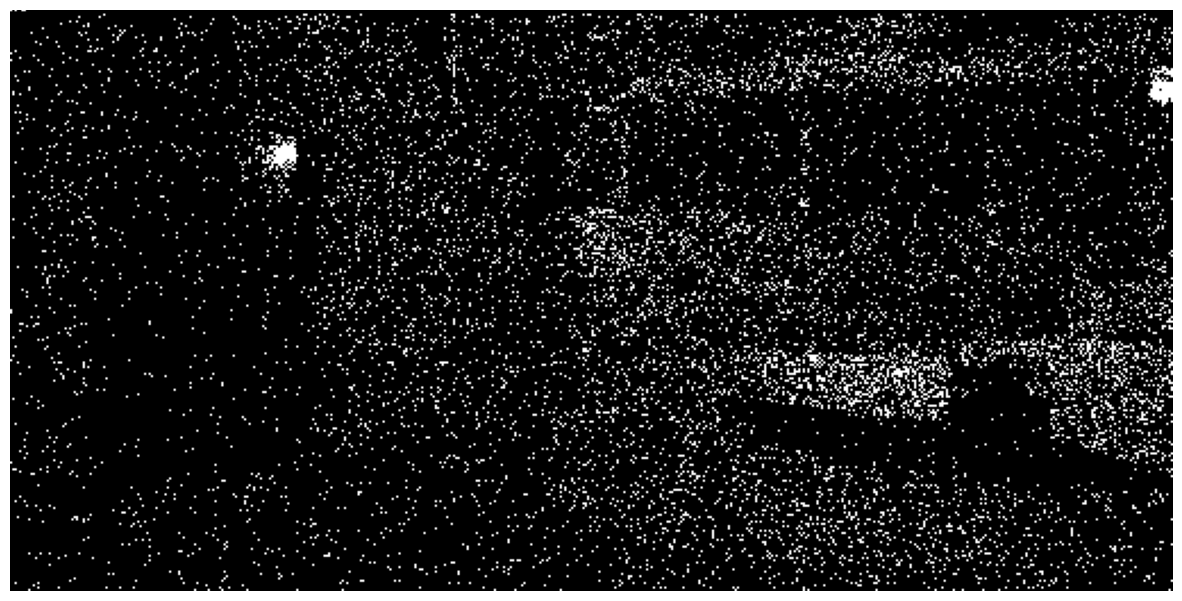

(10000, 256, 512)


Inference #: 100%|██████████| 63/63 [00:29<00:00,  2.17it/s, vram_usage=11.4 GB]


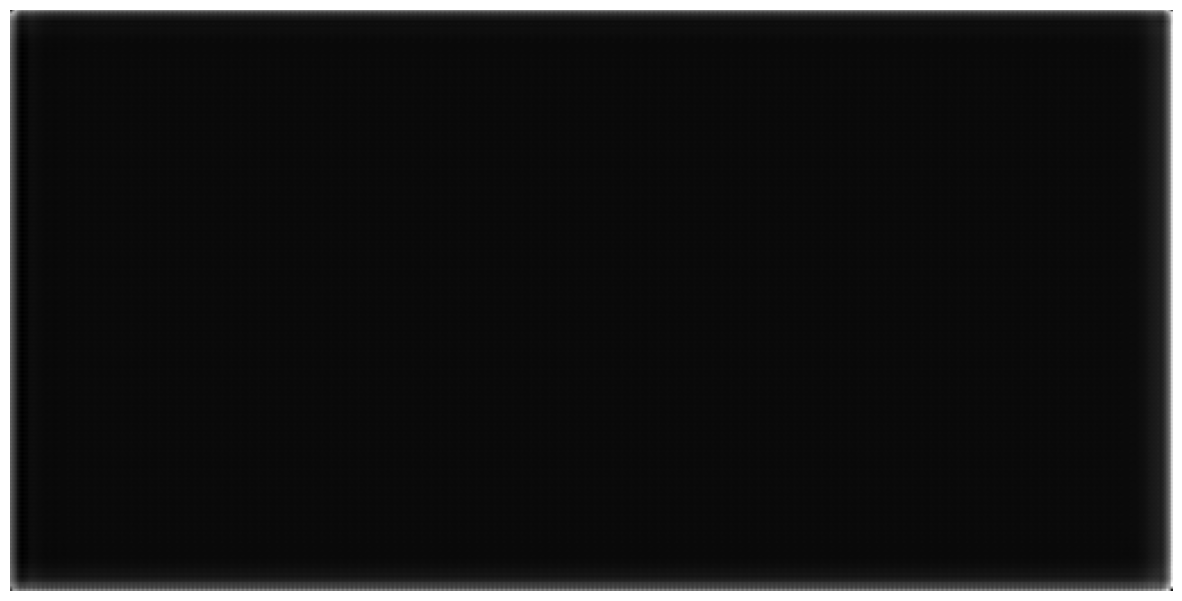

In [ ]:
from src.ssunet.models import Bit2Bit
from src.ssunet.configs import MasterConfig
from tifffile import imread, imwrite
from src.tools.tools import imshow
import h5py
from src.tools.gpuinference import gpu_patch_inference

root_dir = "models/20250528_042245_e=350_p=32_d=1_n=train on 10 sequences, test within the 10_test_1200x32x128x128_skip=1_l=10_d=5_sf=32_ds=2at10_f=10.0_z=3_g=8_sd=0_b=tri_a=gelu"
config_path = root_dir + "/config.yml"
model_path = root_dir + "/logs/version_0/checkpoints/epoch=4-step=1500.ckpt"

config = MasterConfig.from_config(config_path)
model = Bit2Bit.load_from_checkpoint(model_path)
print(config.data_path)
with h5py.File(config.data_path, "r") as f:
    # print(f.keys())
    input = f["bitbit"]
    imshow(input[9000])
    print(input.shape)
    
    # GPU inference with z-patches
    output = gpu_patch_inference(
        model,
        input[9000:, :, :],
        min_overlap=48,
        initial_patch_depth=64,
        device=config.device,
    ) # output shape: (1000, 256, 512)
    imshow(output[100])
    imwrite(root_dir + "/input_512_corner.tif", input)
    imwrite(root_dir + "/inference_512_corner.tif", output)

In [9]:
from src.tools.gpuinference import grid_inference
with h5py.File(config.data_path, "r") as f:
    input = f["bitbit"]
    input = input[9000:, :, :]
    output = grid_inference(input, model, device=config.device, split=5, initial_patch_depth=64)
    imshow(output[100])

Inference #: 100%|██████████| 21/21 [00:09<00:00,  2.21it/s, vram_usage=38.7 GB]
/home/argar/miniconda3/envs/bit2bit/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/argar/miniconda3/envs/bit2bit/lib/python3.10/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
Grid inference:  80%|████████  | 20/25 [02:18<00:34,  6.94s/it]


ValueError: could not broadcast input array from shape (1000,0,256) into shape (1000,225,256)

In [ ]:
from tifffile import imread, imwrite
from src.tools.tools import imshow
import h5py

In [ ]:
inf_out = imread("models/20250515_204942_e=150_p=32_d=[1]_test_600x32x256x256_skip=1_l=10_d=5_sf=32_ds=2at10_f=10.0_z=3_g=8_sd=0_b=tri_a=gelu/inference.tif")
print(inf_out.shape)

In [ ]:
import numpy as np
# create a moviepy clip from the images in inf_out
frames = []
for i in range(inf_out.shape[0]):
    this_img = inf_out[i]
    this_img = this_img - np.min(this_img)
    this_img = this_img / np.max(this_img)
    # repeat in new 3rd dimension
    this_img = np.repeat(this_img[:, :, np.newaxis], 3, axis=2)
    frames.append(this_img)